# Welcome to the Trading Simulator Bot! 🚀

This bot is designed to simulate a trading investment strategy using real-time cryptocurrency data.  
The main purpose is to allow you to explore how different strategies would impact your investment  
in the volatile world of crypto. Currently, the bot offers two strategies: Moving Average (MA) and  
Relative Strength Index (RSI). But don't worry – the code is built with scalability in mind, so you  
can easily add more strategies in the future as you explore different trading techniques.

Once you set your investment amount, the bot will track your balance based on the chosen strategy  
and the market movements of Bitcoin (BTC). You’ll be able to see how your investment performs,  
whether you’re buying during bullish trends or selling during bearish moments – all in the safety  
of a simulation environment. So, get ready to test your trading knowledge and see how your strategy  
performs in real-world market conditions!


Select a strategy: 
1. Moving Average (ma)
2. RSI (rsi)
Purchase made! BTC balance: 0 | USD balance: 1000


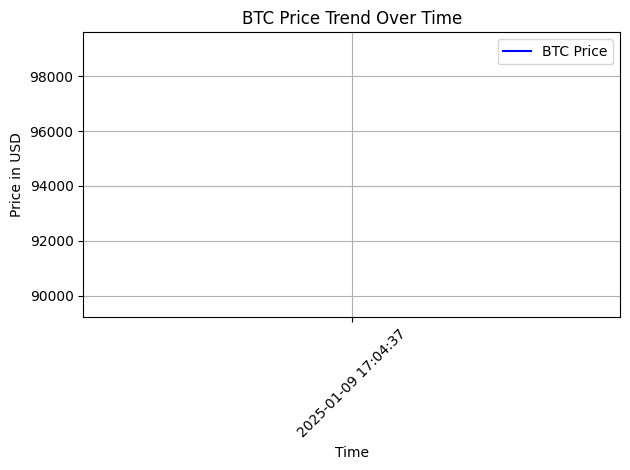

KeyboardInterrupt: 

In [2]:
# This is the version of the code with graph generation enabled.
# It includes the option to generate real-time graphs showing the BTC price over time.
# However, there are two main issues to be aware of:
# 1. When the user inputs data, the amount of Bitcoin (BTC) and the USD balance remain unchanged.
# 2. The graph labels (such as the date and time) do not update during the graph generation process.
# Anyone modifying this code should be aware of these details.

import asyncio
import json
import random
import requests
import matplotlib.pyplot as plt
from datetime import datetime

# Function to get the current BTC/USDT price from CoinGecko
def get_current_price():
    url = "https://api.coingecko.com/api/v3/simple/price?ids=bitcoin&vs_currencies=usd"
    response = requests.get(url)
    data = response.json()
    return data['bitcoin']['usd']  # Bitcoin price in USD

# Function to calculate the Moving Average
def moving_average(prices, period=10):
    if len(prices) < period:
        return None
    return sum(prices[-period:]) / period

# Function to calculate the RSI
def relative_strength_index(prices, period=14):
    if len(prices) < period:
        return None
    gains = 0
    losses = 0
    for i in range(1, period+1):
        change = prices[-i] - prices[-i-1]
        if change > 0:
            gains += change
        elif change < 0:
            losses += abs(change)
    
    avg_gain = gains / period
    avg_loss = losses / period
    
    if avg_loss == 0:
        return 100  # If there are no losses, RSI is 100
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

# Create the trading bot class
class TradingBot:
    def __init__(self, initial_balance, strategy):
        self.initial_balance = initial_balance
        self.current_balance = initial_balance
        self.current_position = 0  # Amount of BTC owned
        self.entry_price = None  # Price at which the purchase was made
        self.transactions = []  # List to track transactions
        self.strategy = strategy
        self.price_history = []  # Price history for calculating indicators

    def simulate_trade(self, investment_amount):
        """Simulate a trade based on the selected strategy."""
        price = get_current_price()  # Current BTC price from CoinGecko
        self.price_history.append(price)
        
        # Check if the buy/sell strategy should be applied
        if self.strategy == "ma":
            ma = moving_average(self.price_history)
            if ma and price > ma and self.current_balance >= investment_amount:
                self.buy(price, investment_amount)
        
        elif self.strategy == "rsi":
            rsi = relative_strength_index(self.price_history)
            if rsi and rsi < 30 and self.current_balance >= investment_amount:
                self.buy(price, investment_amount)

    def buy(self, price, investment_amount):
        """Execute a purchase."""
        quantity = investment_amount / price  # Amount of BTC bought
        self.current_balance -= investment_amount  # Deduct amount from account
        self.current_position += quantity  # Add the purchased BTC to balance
        self.entry_price = price
        self.transactions.append({
            'type': 'buy',
            'quantity': quantity,
            'price': price,
            'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        })
        
        # Print the alert
        print(f"Purchase made! BTC balance: {self.current_position} | USD balance: {self.current_balance}")

    def save_investment(self, filename="investments.json"):
        """Save investment data in a JSON file."""
        data = {
            "initial_balance": self.initial_balance,
            "current_balance": self.current_balance,
            "current_position": self.current_position,
            "entry_price": self.entry_price,
            "transactions": self.transactions
        }
        with open(filename, "w") as file:
            json.dump(data, file, indent=4)

    def get_portfolio(self):
        """Return the total balance in USD, considering the BTC balance."""
        if self.current_position > 0:
            current_price = get_current_price()  # Current BTC price
            return self.current_balance + self.current_position * current_price
        return self.current_balance

# Function to update the graph every 10 seconds
async def update_graph(prices, timestamps):
    while True:
        plt.clf()  # Clears the previous graph
        plt.plot(timestamps, prices, label="BTC Price", color="blue")
        plt.xlabel("Time")
        plt.ylabel("Price in USD")
        plt.title("BTC Price Trend Over Time")
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.draw()  # Forces a redraw of the graph
        plt.pause(0.1)  # Short pause to avoid blocking execution
        await asyncio.sleep(10)  # Update every 10 seconds

# Main function for trading and updating graphs
async def main():
    # Ask the user to choose a strategy
    print("Select a strategy: ")
    print("1. Moving Average (ma)")
    print("2. RSI (rsi)")
    choice = input("Enter 'ma' for Moving Average or 'rsi' for RSI: ").strip().lower()

    # Ask the user how much money they want to invest
    investment_amount = float(input("Enter the amount you want to invest in USD: ").strip())

    # Create the bot with the chosen strategy
    bot = TradingBot(initial_balance=1000, strategy=choice)

    prices = []
    timestamps = []
    
    while True:
        # Simulate a trade every 10 seconds
        bot.simulate_trade(investment_amount)
        print(f"Purchase made! BTC balance: {bot.current_position} | USD balance: {bot.current_balance}")
        
        # Add data for the graph
        current_price = get_current_price()  # Current BTC price from CoinGecko
        prices.append(current_price)
        timestamps.append(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
        
        # Save the investment each time
        bot.save_investment()

        # Update the graph
        await asyncio.gather(
            update_graph(prices, timestamps)  # Update the graph every 10 seconds
        )

# Run the bot using nest_asyncio to integrate with the IPython event loop
import nest_asyncio
nest_asyncio.apply() 
asyncio.run(main())


In [ ]:
# This is the version of the code without graph generation.
# It does not include real-time graph generation, but it still tracks the amount of Bitcoin (BTC)
# and the USD balance. This version performs trades based on the strategy selected by the user
# and updates the portfolio accordingly, but does not update any visual graphs in real-time.
# 
# Note: If the investment amount exceeds 1000 USD, the output will display an amount that requires
# evaluation. It seems that the displayed result is not faithful to the amount entered. Specifically,
# the output may incorrectly show "USD 1000 and BTC 0", which indicates an issue with how the
# amount is tracked or displayed in the code.

import asyncio
import json
import requests
from datetime import datetime

# Function to get the current BTC/USDT price from CoinGecko
def get_current_price():
    url = "https://api.coingecko.com/api/v3/simple/price?ids=bitcoin&vs_currencies=usd"
    response = requests.get(url)
    data = response.json()
    return data['bitcoin']['usd']  # Bitcoin price in USD

# Create the trading bot class
class TradingBot:
    def __init__(self, initial_balance, strategy):
        self.initial_balance = initial_balance
        self.current_balance = initial_balance
        self.current_position = 0  # Amount of BTC owned
        self.entry_price = None  # Price at which the purchase was made
        self.transactions = []  # List to track transactions
        self.strategy = strategy
        self.price_history = []  # Price history for calculating indicators

    def simulate_trade(self, investment_amount):
        """Simulate a trade based on the selected strategy."""
        price = get_current_price()  # Current BTC price from CoinGecko
        self.price_history.append(price)
        
        # Force purchase without checking the strategy (for testing purposes)
        if self.current_balance >= investment_amount:
            self.buy(price, investment_amount)

    def buy(self, price, investment_amount):
        """Execute a purchase."""
        quantity = investment_amount / price  # Amount of BTC bought
        print(f"BTC Price: {price} | Quantity Bought: {quantity}")  # Add this line
        self.current_balance -= investment_amount  # Deduct the amount from the account
        self.current_position += quantity  # Add the purchased BTC to balance
        self.entry_price = price
        self.transactions.append({
            'type': 'buy',
            'quantity': quantity,
            'price': price,
            'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        })
        
        # Print the alert
        print(f"Purchase made! BTC Balance: {self.current_position} | USD Balance: {self.current_balance}")

    def save_investment(self, filename="investments.json"):
        """Save investment data in a JSON file."""
        data = {
            "initial_balance": self.initial_balance,
            "current_balance": self.current_balance,
            "current_position": self.current_position,
            "entry_price": self.entry_price,
            "transactions": self.transactions
        }
        with open(filename, "w") as file:
            json.dump(data, file, indent=4)

    def get_portfolio(self):
        """Return the total balance in USD, considering the BTC balance."""
        if self.current_position > 0:
            current_price = get_current_price()  # Current BTC price
            return self.current_balance + self.current_position * current_price
        return self.current_balance

# Function to handle user input synchronously
def get_user_input():
    print("Select a strategy: ")
    print("1. Moving Average (ma)")
    print("2. RSI (rsi)")
    choice = input("Enter 'ma' for Moving Average or 'rsi' for RSI: ").strip().lower()

    investment_amount = float(input("Enter the amount you want to invest in USD: ").strip())
    return choice, investment_amount

# Main function for trading (without graph update)
async def main():
    # Get input from the user synchronously
    strategy, investment_amount = get_user_input()

    # Create the bot with the selected strategy
    bot = TradingBot(initial_balance=1000, strategy=strategy)

    # Simulate a trade every 10 seconds
    bot.simulate_trade(investment_amount)
    
    # Output the investment status
    print(f"Purchase made! BTC Balance: {bot.current_position} | USD Balance: {bot.current_balance}")

    # Save the investment
    bot.save_investment()

# Run the main function without blocking the event loop
import nest_asyncio
nest_asyncio.apply()

# Call the asynchronous function
asyncio.run(main())
